In [1]:
#CT image reconstruct through the FBP algorithm
#Written by Ren-Qi Pan
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import pandas as pd
import math
import cucim

In [2]:
import os
from pydicom import dcmread
import matplotlib.pyplot as plt
from scipy.interpolate import RectBivariateSpline
from skimage.data import shepp_logan_phantom
from skimage.transform import radon, rescale, rotate, iradon, iradon_sart
import cv2
import numpy as np
from tqdm import tqdm

In [3]:
os.getcwd()

'/mnt/d/cmc/pyprojects/radio_therapy/dose-3d/notebooks'

In [4]:
_pth = '/mnt/f/EPID Images/sphere/854320165'
# _pth = r'F:\EPID Images\2024-05-04 17-12-18-MV Dosimetry-6x_Patient 1_Arc CW\854320170'
_files = os.listdir(_pth)

In [5]:
dcm = dcmread(os.path.join(_pth, _files[0]))
shape = dcm.Rows, dcm.Columns

In [6]:
g_angle = []
_images = np.zeros((len(_files),shape[0], shape[0]), dtype=np.uint16)
prev = np.zeros((shape[0], shape[0]), dtype=np.uint16)
curr = np.zeros((shape[0], shape[0]), dtype=np.uint16)
_raw_datas = []
for idx, _fname in enumerate(tqdm(_files)):
    raw = dcmread(os.path.join(_pth, _fname))
    curr = raw.pixel_array
    
    _m = curr - prev
    
    if np.max(_m) > 10000:
        _images[idx, :, :] = _images[idx-1, :, :]
        g_angle.append(g_angle[idx-1])
    else:
        _images[idx, :, :] = curr - prev
        prev = curr
        g_angle.append(raw.GantryAngle)
        
    prev = curr


100%|██████████| 412/412 [00:24<00:00, 16.66it/s]


In [7]:
g_angle = np.array(g_angle)
sorted_inx = np.argsort(g_angle)

sorted_images = np.zeros((len(_files),shape[0], shape[0]), dtype=np.uint16)

for idx, val in enumerate(tqdm(sorted_inx)):
    sorted_images[idx, :, :] = _images[val, :, :]

100%|██████████| 412/412 [00:00<00:00, 776.23it/s]


In [8]:
g_angle2 = g_angle[sorted_inx]
_images = []

In [9]:
#define the filter function: Ram-Lak (R-L) filter and the Shepp-Logan(S-L) filter
#N:number of detector cells
#d: step width of detector cells
PI=math.pi
def filter_RL(N, d):
    fh_RL=np.zeros(N)
    for k1 in range(0,N,1):
        if k1 != int(N/2):     
            if int(k1-N/2) % 2 ==0:
                fh_RL[k1]=0.0
            else:
                fh_RL[k1]=-1.0/(PI*PI*((k1-N/2.0)*d)**2)
        else:
            fh_RL[int(N/2)]=1.0/(4*d**2)
    return fh_RL
def filter_SL(N,d):
    fh_SL=np.zeros(N)
    for k1 in range(0,N,1):
        fh_SL[k1]=-2.0/(PI*PI*d*d*(4*(k1-N/2.0)**2-1))
    return fh_SL
def nearestPowerOf2(N):
    # Calculate log2 of N
    a = int(math.log2(N))
    if 2**a == N:
        return N
    return 2**(a + 1)

In [10]:
def Fun_Weigth_Projection(projection_beta,SOD,delta_dd):
    Nrows,Ncolumns=projection_beta.shape
    dd_column=delta_dd*np.arange(-Ncolumns/2+0.5,(Ncolumns/2+1)-0.5,1.0)#coordinate of detector cell in horizontal 
    dd_row=delta_dd*np.arange(-Nrows/2+0.5,(Nrows/2+1)-0.5,1.0)#coordinate of detector cell in vertical
    dd_row2D,dd_column2D=np.meshgrid(dd_row,dd_column,indexing='ij')
    weighted_projection=projection_beta*SOD/np.sqrt(SOD*SOD+np.power(dd_row2D,2.0)+np.power(dd_column2D,2.0))
    return weighted_projection
def Fun_Filter_Projection(weighted_projection,fh_RL):
    Nrows,Ncolumns=weighted_projection.shape
    Nfft=nearestPowerOf2(2*Ncolumns-1)
    filtered_projection=np.zeros((Nrows,Ncolumns))
    for row in range(Nrows):
        projection_row=weighted_projection[row,:]
        zeros_pad=np.zeros(Nfft-Ncolumns)
        projection_row=np.concatenate((projection_row,zeros_pad))
        convoluted_time=np.convolve(projection_row,fh_RL/2.0,mode='same')
        # pro_fft=np.fft.fft(projection_row,Nfft)
        # filter_fft=np.fft.fft(fh_RL/2.0,Nfft)
        # convoluted_frequency=pro_fft*np.abs(filter_fft)
        # convoluted_time=np.real(np.fft.ifft(convoluted_frequency))
        convoluted_time=convoluted_time[:Ncolumns]
        filtered_projection[row,:]=convoluted_time
    return filtered_projection

def Fun_BackProjection(filtered_projection,SOD,beta_num,beta_m,delta_dd,Nimage):
    Nrows,Ncolumns=filtered_projection.shape
    MX, MZ=Nimage,int(Nimage*Nrows/Ncolumns)
    #roi[0], roi[1]: the min and max of x-axis and y-axis
    #roi[2],roi[3]: the min and max of z-axis
    roi=delta_dd*np.array([-Ncolumns/2.0+0.5,Ncolumns/2.0-0.5,-Nrows/2.0+0.5,Nrows/2.0-0.5])
    hx=(roi[1]-roi[0])/(MX-1) #interval of x-axis and y-axis
    xrange=roi[0]+hx*np.arange(0,MX) #coordinate vector of x-axis and y-axis 
    hy=(roi[3]-roi[2])/(MZ-1) #interval of z-axis
    yrange=roi[2]+hy*np.arange(0,MZ) #coordinate vector of z-axis 
    XX,YY,ZZ=np.meshgrid(xrange,xrange,yrange,indexing='ij')
    # print(XX.shape, YY.shape,ZZ.shape)
    temp_rec=np.zeros((MX,MX,MZ)) #store back projection contribution
    U=(SOD+XX*np.sin(beta_m)-YY*np.cos(beta_m))/SOD
    a=(XX*np.cos(beta_m)+YY*np.sin(beta_m))/U
    xx=np.int32(np.floor(a/delta_dd)) #beam numbering,strart from -Ncolumns/2
    u1=a/delta_dd-xx  #the decimal part of a
    b=ZZ/U
    yy=np.int32(np.floor(b/delta_dd)) #beam numbering,strart from -Nrows/2
    u2=b/delta_dd-yy #the decimal part of b
    xx=xx+int(Ncolumns/2) #numbering from 0
    yy=yy+int(Nrows/2) #numbering from 0
    mask=np.where((xx >=0) & (xx< Ncolumns-1) & (yy >=0) & (yy<Nrows-1))
    xx=xx[mask]
    yy=yy[mask]
    u1=u1[mask]
    u2=u2[mask]
    temp=(1-u1)*(1-u2)*filtered_projection[yy,xx]+(1-u1)*u2*filtered_projection[yy+1,xx]+\
                 (1-u2)*u1*filtered_projection[yy,xx+1]+u1*u2*filtered_projection[yy+1,xx+1]
    temp_rec[mask]=temp_rec[mask]+temp/(np.power(U[mask],2))*2*PI/beta_num
    print('backprojection, beta: ',round(beta_m*180/PI,1))
    return temp_rec


In [11]:
import cupy as cp
import cucim.skimage

def Fun_Weigth_Projection(projection_beta, SOD, delta_dd):
    Nrows, Ncolumns = projection_beta.shape
    dd_column = delta_dd * cp.arange(-Ncolumns / 2 + 0.5, Ncolumns / 2 + 0.5, 1.0)
    dd_row = delta_dd * cp.arange(-Nrows / 2 + 0.5, Nrows / 2 + 0.5, 1.0)
    dd_row2D, dd_column2D = cp.meshgrid(dd_row, dd_column, indexing='ij')
    weighted_projection = projection_beta * SOD / cp.sqrt(SOD * SOD + cp.power(dd_row2D, 2.0) + cp.power(dd_column2D, 2.0))
    return weighted_projection

def nearestPowerOf2(x):
    return 1 << (x - 1).bit_length()

def Fun_Filter_Projection(weighted_projection, fh_RL):
    Nrows, Ncolumns = weighted_projection.shape
    Nfft = nearestPowerOf2(2 * Ncolumns - 1)
    filtered_projection = cp.zeros((Nrows, Ncolumns))
    fh_RL_gpu = cp.asarray(fh_RL)

    for row in range(Nrows):
        projection_row = weighted_projection[row, :]
        zeros_pad = cp.zeros(Nfft - Ncolumns)
        projection_row = cp.concatenate((projection_row, zeros_pad))
        convoluted_time = cp.convolve(projection_row, fh_RL_gpu / 2.0, mode='same')
        convoluted_time = convoluted_time[:Ncolumns]
        filtered_projection[row, :] = convoluted_time

    return filtered_projection

def Fun_BackProjection(filtered_projection, SOD, beta_num, beta_m, delta_dd, Nimage):
    Nrows, Ncolumns = filtered_projection.shape
    MX, MZ = Nimage, int(Nimage * Nrows / Ncolumns)
    roi = delta_dd * cp.array([-Ncolumns / 2.0 + 0.5, Ncolumns / 2.0 - 0.5, -Nrows / 2.0 + 0.5, Nrows / 2.0 - 0.5])
    hx = (roi[1] - roi[0]) / (MX - 1)
    xrange = roi[0] + hx * cp.arange(0, MX)
    hy = (roi[3] - roi[2]) / (MZ - 1)
    yrange = roi[2] + hy * cp.arange(0, MZ)
    XX, YY, ZZ = cp.meshgrid(xrange, xrange, yrange, indexing='ij')
    temp_rec = cp.zeros((MX, MX, MZ))

    U = (SOD + XX * cp.sin(beta_m) - YY * cp.cos(beta_m)) / SOD
    a = (XX * cp.cos(beta_m) + YY * cp.sin(beta_m)) / U
    xx = cp.int32(cp.floor(a / delta_dd))
    u1 = a / delta_dd - xx
    b = ZZ / U
    yy = cp.int32(cp.floor(b / delta_dd))
    u2 = b / delta_dd - yy
    xx = xx + int(Ncolumns / 2)
    yy = yy + int(Nrows / 2)

    mask = (xx >= 0) & (xx < Ncolumns - 1) & (yy >= 0) & (yy < Nrows - 1)
    xx = xx[mask]
    yy = yy[mask]
    u1 = u1[mask]
    u2 = u2[mask]
    
    temp = (1 - u1) * (1 - u2) * filtered_projection[yy, xx] + \
           (1 - u1) * u2 * filtered_projection[yy + 1, xx] + \
           (1 - u2) * u1 * filtered_projection[yy, xx + 1] + \
           u1 * u2 * filtered_projection[yy + 1, xx + 1]
    
    temp_rec[mask] += temp / (cp.power(U[mask], 2)) * 2 * cp.pi / beta_num
    print('backprojection, beta: ', round(beta_m * 180 / cp.pi, 1))
    
    return temp_rec


In [12]:
def ConeBeam_FDK_Backprojection(projection,fh_RL,beta,SOD,Nimage,delta_dd):
    # projection: projection data in 3D, (angle,row, colums)
    # fh_RL: R-L filter function
    # beta: rotate angles in degrees
    # SOD: source to rotation center distance in mm unit
    # delta_dd: interval of the virtual detector cell
    Ncolumns=projection.shape[2]
    Nrows=projection.shape[1]
    rec_image=np.zeros((Nimage,Nimage,int(Nimage*Nrows/Ncolumns)))
    beta_num=len(beta) #number of angles
    beta=beta*PI/180.0 # view angle in radian
    for m in range(0, beta_num,1):
        projection_beta=projection[m,:,:] #projection matrix at the beta angle
        weighted_projection=Fun_Weigth_Projection(projection_beta,SOD,delta_dd)
        filtered_projection=Fun_Filter_Projection(weighted_projection,fh_RL)
        rec_image=rec_image+Fun_BackProjection(filtered_projection,SOD,beta_num,beta[m],delta_dd,Nimage)
    return rec_image

In [13]:
def ConeBeam_FDK_Backprojection(projection, fh_RL, beta, SOD, Nimage, delta_dd):
    # projection: projection data in 3D, (angle, row, columns)
    # fh_RL: R-L filter function
    # beta: rotate angles in degrees
    # SOD: source to rotation center distance in mm unit
    # delta_dd: interval of the virtual detector cell
    
    Ncolumns = projection.shape[2]
    Nrows = projection.shape[1]
    rec_image = cp.zeros((Nimage, Nimage, int(Nimage * Nrows / Ncolumns)))
    beta_num = len(beta)  # number of angles
    beta = beta * cp.pi / 180.0  # view angle in radians
    
    for m in range(beta_num):
        projection_beta = cp.asarray(projection[m, :, :])  # projection matrix at the beta angle
        weighted_projection = Fun_Weigth_Projection(projection_beta, SOD, delta_dd)
        filtered_projection = Fun_Filter_Projection(weighted_projection, fh_RL)
        rec_image += Fun_BackProjection(filtered_projection, SOD, beta_num, beta[m], delta_dd, Nimage)
    
    return rec_image

In [14]:
sorted_images.shape

(412, 1190, 1190)

In [15]:
Ncolumns = sorted_images.shape[2]

In [16]:
SID = dcm.RTImageSID
SAD = dcm.RadiationMachineSAD

In [17]:
dcm

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 196
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: RT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.246.352.99.4.4878315889050753865.8132004005248594593
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.246.352.70.2.1.70.2
(0002, 0013) Implementation Version Name         SH: 'MergeCOM3_460'
-------------------------------------------------
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'PORTAL']
(0008, 0012) Instance Creation Date              DA: '20240506'
(0008, 0013) Instance Creation Time              TM: '081123'
(0008, 0016) SOP Class UID                       UI: RT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.246.352.99.4.4878315889050753865.

TypeError: Unsupported type <class 'numpy.ndarray'>

In [39]:
import cupy as cp
import cucim.skimage as ski
import math

# Define the filter function: Ram-Lak (R-L) filter and the Shepp-Logan(S-L) filter
# N: number of detector cells
# d: step width of detector cells
PI = math.pi

def filter_RL(N, d):
    fh_RL = cp.zeros(N)
    for k1 in range(0, N, 1):
        if k1 != int(N / 2):
            if int(k1 - N / 2) % 2 == 0:
                fh_RL[k1] = 0.0
            else:
                fh_RL[k1] = -1.0 / (PI * PI * ((k1 - N / 2.0) * d) ** 2)
        else:
            fh_RL[int(N / 2)] = 1.0 / (4 * d ** 2)
    return fh_RL

def filter_SL(N, d):
    fh_SL = cp.zeros(N)
    for k1 in range(0, N, 1):
        fh_SL[k1] = -2.0 / (PI * PI * d * d * (4 * (k1 - N / 2.0) ** 2 - 1))
    return fh_SL

def nearestPowerOf2(N):
    a = int(math.log2(N))
    if 2 ** a == N:
        return N
    return 2 ** (a + 1)

def Fun_Weigth_Projection(projection_beta, SOD, delta_dd):
    Nrows, Ncolumns = projection_beta.shape
    dd_column = delta_dd * cp.arange(-Ncolumns / 2 + 0.5, (Ncolumns / 2 + 1) - 0.5, 1.0)  # coordinate of detector cell in horizontal 
    dd_row = delta_dd * cp.arange(-Nrows / 2 + 0.5, (Nrows / 2 + 1) - 0.5, 1.0)  # coordinate of detector cell in vertical
    dd_row2D, dd_column2D = cp.meshgrid(dd_row, dd_column, indexing='ij')
    weighted_projection = projection_beta * SOD / cp.sqrt(SOD * SOD + cp.power(dd_row2D, 2.0) + cp.power(dd_column2D, 2.0))
    return weighted_projection

def Fun_Filter_Projection(weighted_projection, fh_RL):
    Nrows, Ncolumns = weighted_projection.shape
    Nfft = nearestPowerOf2(2 * Ncolumns - 1)
    filtered_projection = cp.zeros((Nrows, Ncolumns))
    for row in range(Nrows):
        projection_row = weighted_projection[row, :]
        zeros_pad = cp.zeros(Nfft - Ncolumns)
        projection_row = cp.concatenate((projection_row, zeros_pad))
        convoluted_time = cp.convolve(projection_row, fh_RL / 2.0, mode='same')
        convoluted_time = convoluted_time[:Ncolumns]
        filtered_projection[row, :] = convoluted_time
    return filtered_projection

def Fun_BackProjection(filtered_projection, SOD, beta_num, beta_m, delta_dd, Nimage):
    Nrows, Ncolumns = filtered_projection.shape
    MX, MZ = Nimage, int(Nimage * Nrows / Ncolumns)
    roi = delta_dd * cp.array([-Ncolumns / 2.0 + 0.5, Ncolumns / 2.0 - 0.5, -Nrows / 2.0 + 0.5, Nrows / 2.0 - 0.5])
    hx = (roi[1] - roi[0]) / (MX - 1)  # interval of x-axis and y-axis
    xrange = roi[0] + hx * cp.arange(0, MX)  # coordinate vector of x-axis and y-axis 
    hy = (roi[3] - roi[2]) / (MZ - 1)  # interval of z-axis
    yrange = roi[2] + hy * cp.arange(0, MZ)  # coordinate vector of z-axis 
    XX, YY, ZZ = cp.meshgrid(xrange, xrange, yrange, indexing='ij')
    temp_rec = cp.zeros((MX, MX, MZ))  # store back projection contribution
    U = (SOD + XX * cp.sin(beta_m) - YY * cp.cos(beta_m)) / SOD
    a = (XX * cp.cos(beta_m) + YY * cp.sin(beta_m)) / U
    xx = cp.int32(cp.floor(a / delta_dd))  # beam numbering, start from -Ncolumns/2
    u1 = a / delta_dd - xx  # the decimal part of a
    b = ZZ / U
    yy = cp.int32(cp.floor(b / delta_dd))  # beam numbering, start from -Nrows/2
    u2 = b / delta_dd - yy  # the decimal part of b
    xx = xx + int(Ncolumns / 2)  # numbering from 0
    yy = yy + int(Nrows / 2)  # numbering from 0
    mask = (xx >= 0) & (xx < Ncolumns - 1) & (yy >= 0) & (yy < Nrows - 1)
    xx = xx[mask]
    yy = yy[mask]
    u1 = u1[mask]
    u2 = u2[mask]
    temp = (1 - u1) * (1 - u2) * filtered_projection[yy, xx] + (1 - u1) * u2 * filtered_projection[yy + 1, xx] + \
           (1 - u2) * u1 * filtered_projection[yy, xx + 1] + u1 * u2 * filtered_projection[yy + 1, xx + 1]
    temp_rec[mask] = temp_rec[mask] + temp / (cp.power(U[mask], 2)) * 2 * PI / beta_num
    print('Backprojection, beta:', round(beta_m * 180 / PI, 1))
    return temp_rec

def ConeBeam_FDK_Backprojection(projection, fh_RL, beta, SOD, Nimage, delta_dd):
    Ncolumns = projection.shape[2]
    Nrows = projection.shape[1]
    rec_image = cp.zeros((Nimage, Nimage, int(Nimage * Nrows / Ncolumns)))
    beta_num = len(beta)  # number of angles
    beta = beta * PI / 180.0  # view angle in radian
    for m in range(beta_num):
        projection_beta = projection[m, :, :]  # projection matrix at the beta angle
        print(projection_beta.shape, type(projection_beta))
        weighted_projection = Fun_Weigth_Projection(projection_beta, SOD, delta_dd)
        filtered_projection = Fun_Filter_Projection(weighted_projection, fh_RL)
        rec_image = rec_image + Fun_BackProjection(filtered_projection, SOD, beta_num, beta[m], delta_dd, Nimage)
    return rec_image


In [58]:
import cupy as cp
import math

# Constants
PI = math.pi

# Parameters
N = 1190  # Number of detector cells
d = 1.0  # Step width of detector cells
SOD=SAD#source to origin distance, in unit mm
SDD=SID #source to center of detector, in unit mm
delta_dd = 1.0  # Interval of the virtual detector cell
Nimage = images.shape[0]  # Number of image pixels
beta = cp.array(g_angle2)  # Rotation angles in degrees

# Step 1: Define the Ram-Lak (R-L) filter
fh_RL = cp.zeros(N)
for k1 in range(N):
    if k1 != int(N / 2):
        if int(k1 - N / 2) % 2 == 0:
            fh_RL[k1] = 0.0
        else:
            fh_RL[k1] = -1.0 / (PI * PI * ((k1 - N / 2.0) * d) ** 2)
    else:
        fh_RL[int(N / 2)] = 1.0 / (4 * d ** 2)

# Step 2: Define the Shepp-Logan (S-L) filter
fh_SL = cp.zeros(N)
for k1 in range(N):
    fh_SL[k1] = -2.0 / (PI * PI * d * d * (4 * (k1 - N / 2.0) ** 2 - 1))

# Step 3: Calculate the nearest power of 2 for FFT
def nearestPowerOf2(N):
    a = int(math.log2(N))
    if 2 ** a == N:
        return N
    return 2 ** (a + 1)

# Simulated projection data (angle, row, column)
projection = cp.random.rand(len(beta), N, N)

# Step 4: Initialize variables for ConeBeam FDK Backprojection
Ncolumns = projection.shape[2]
Nrows = projection.shape[1]
rec_image = cp.zeros((Nimage, Nimage, int(Nimage * Nrows / Ncolumns)))
beta_num = len(beta)  # number of angles
beta = beta * PI / 180.0  # view angle in radian

for m in range(beta_num):
    projection_beta = projection[m, :, :]  # projection matrix at the beta angle
    
    # Step 5: Weight projection
    dd_column = delta_dd * cp.arange(-Ncolumns / 2 + 0.5, (Ncolumns / 2 + 1) - 0.5, 1.0)
    dd_row = delta_dd * cp.arange(-Nrows / 2 + 0.5, (Nrows / 2 + 1) - 0.5, 1.0)
    dd_row2D, dd_column2D = cp.meshgrid(dd_row, dd_column, indexing='ij')
    weighted_projection = projection_beta * cp.float16(SOD) / cp.sqrt(SOD * SOD + cp.power(dd_row2D, 2.0) + cp.power(dd_column2D, 2.0))
    
    # Step 6: Filter projection
    Nfft = nearestPowerOf2(2 * Ncolumns - 1)
    filtered_projection = cp.zeros((Nrows, Ncolumns))
    for row in range(Nrows):
        projection_row = weighted_projection[row, :]
        zeros_pad = cp.zeros(Nfft - Ncolumns)
        projection_row = cp.concatenate((projection_row, zeros_pad))
        convoluted_time = cp.convolve(projection_row, fh_RL / 2.0, mode='same')
        convoluted_time = convoluted_time[:Ncolumns]
        filtered_projection[row, :] = convoluted_time

    # Step 7: Backprojection
    MX, MZ = Nimage, int(Nimage * Nrows / Ncolumns)
    roi = delta_dd * cp.array([-Ncolumns / 2.0 + 0.5, Ncolumns / 2.0 - 0.5, -Nrows / 2.0 + 0.5, Nrows / 2.0 - 0.5])
    hx = (roi[1] - roi[0]) / (MX - 1)
    xrange = roi[0] + hx * cp.arange(0, MX)
    hy = (roi[3] - roi[2]) / (MZ - 1)
    yrange = roi[2] + hy * cp.arange(0, MZ)
    XX, YY, ZZ = cp.meshgrid(xrange, xrange, yrange, indexing='ij')
    temp_rec = cp.zeros((MX, MX, MZ))
    U = (SOD + XX * cp.sin(beta[m]) - YY * cp.cos(beta[m])) / SOD
    a = (XX * cp.cos(beta[m]) + YY * cp.sin(beta[m])) / U
    xx = cp.floor(a/delta_dd).astype(cp.int32)
    u1 = a / delta_dd - xx
    b = ZZ / U
    yy = cp.floor(b/delta_dd).astype(cp.int32)
    u2 = b / delta_dd - yy
    xx = xx + int(Ncolumns / 2)
    yy = yy + int(Nrows / 2)
    mask = (xx >= 0) & (xx < Ncolumns - 1) & (yy >= 0) & (yy < Nrows - 1)
    xx = xx[mask]
    yy = yy[mask]
    u1 = u1[mask]
    u2 = u2[mask]
    temp = (1 - u1) * (1 - u2) * filtered_projection[yy, xx] + (1 - u1) * u2 * filtered_projection[yy + 1, xx] + \
           (1 - u2) * u1 * filtered_projection[yy, xx + 1] + u1 * u2 * filtered_projection[yy + 1, xx + 1]
    temp_rec[mask] = temp_rec[mask] + temp / (cp.power(U[mask], 2)) * 2 * PI / beta_num
    rec_image = rec_image + temp_rec
    print('Backprojection, beta:', round(beta[m].get() * 180 / PI, 1))

# The result is stored in rec_image


OutOfMemoryError: Out of memory allocating 4,667,465,728 bytes (allocated so far: 9,052,210,176 bytes).

In [59]:
import cupy as cp
import math

# Constants
PI = math.pi

# Parameters
N = 1190  # Number of detector cells
d = 1.0  # Step width of detector cells
SOD = SAD  # source to origin distance, in unit mm
SDD = SID  # source to center of detector, in unit mm
delta_dd = 1.0  # Interval of the virtual detector cell
Nimage = images.shape[0]  # Number of image pixels
beta = cp.array(g_angle2) * PI / 180.0  # View angle in radians

# Step 1: Define the Ram-Lak (R-L) filter (vectorized)
mask_center = N // 2
mask_odd = (cp.arange(N) != mask_center)
fh_RL = cp.where(mask_odd & (mask_odd % 2 == 0), 0.0,
                 cp.where(~mask_odd, 1.0 / (4 * d ** 2),
                          -1.0 / (PI * PI * ((cp.arange(N) - mask_center) * d) ** 2)))

# Simulated projection data (angle, row, column)
projection = cp.random.rand(len(beta), N, N)

# Step 4: Initialize variables for ConeBeam FDK Backprojection
Ncolumns = projection.shape[2]
Nrows = projection.shape[1]
rec_image = cp.zeros((Nimage, Nimage, int(Nimage * Nrows / Ncolumns)))
beta_num = len(beta)

for m in range(tqdm(beta_num)):
    projection_beta = projection[m, :, :]

    # Step 5: Weight projection (vectorized)
    dd_column = delta_dd * cp.arange(-Ncolumns / 2 + 0.5, (Ncolumns / 2 + 1) - 0.5, 1.0)
    dd_row = delta_dd * cp.arange(-Nrows / 2 + 0.5, (Nrows / 2 + 1) - 0.5, 1.0)
    dd_row2D, dd_column2D = cp.meshgrid(dd_row, dd_column, indexing='ij')
    weighted_projection = projection_beta * cp.float16(SOD) / cp.sqrt(SOD**2 + cp.power(dd_row2D, 2.0) + cp.power(dd_column2D, 2.0))

    # Step 6: Filter projection (cuFFT)
    Nfft = nearestPowerOf2(2 * Ncolumns - 1)
    filtered_projection = cp.zeros((Nrows, Ncolumns))

    projection_freq = cp.fft.fft(cp.pad(weighted_projection, (0, Nfft - Ncolumns), mode='constant'))
    filter_freq = cp.fft.fft(fh_RL[:Nfft])

    filtered_freq = projection_freq * filter_freq
    filtered_projection = cp.fft.ifft(filtered_freq)[:Ncolumns].real

    # ... rest of the backprojection (potential loop optimizations)



OutOfMemoryError: Out of memory allocating 4,667,465,728 bytes (allocated so far: 9,052,210,176 bytes).

In [55]:
projection_beta * cp.float16(SOD)

array([[105.4059319 , 863.06771023, 501.0611419 , ..., 235.62580689,
          9.05859594, 677.42059672],
       [445.99636923, 679.70126152, 847.46963607, ..., 930.4079048 ,
        396.39906839, 908.06202743],
       [402.71612614, 127.93318968, 685.01966054, ..., 189.74483952,
          8.6107451 , 106.43917188],
       ...,
       [507.42276076, 109.71727221, 805.86180238, ..., 824.4996078 ,
        286.82646124, 435.08362327],
       [895.47776285, 532.49620492, 828.34083802, ..., 404.11269992,
        188.43432188, 545.72014726],
       [755.71950341, 593.16861978, 149.18882316, ..., 369.05102038,
         46.17245496, 235.1957731 ]])

In [48]:
SOD / cp.sqrt(SOD * SOD + cp.power(dd_row2D, 2.0) + cp.power(dd_column2D, 2.0))

TypeError: Unsupported type <class 'pydicom.valuerep.DSfloat'>

In [57]:
weighted_projection = projection_beta * cp.float16(SOD) / cp.sqrt(SOD * SOD + cp.power(dd_row2D, 2.0) + cp.power(dd_column2D, 2.0))


In [40]:
Nimage=250 #size of image
beta=g_angle2 #rotate(view) angles
SOD=SAD#source to origin distance, in unit mm
SDD=SID #source to center of detector, in unit mm
width=0.172 #size of detector cell, in unit mm
delta_dd=width*SOD/SDD #interval of the virtual detector cell
Nfft=nearestPowerOf2(2*Ncolumns-1) #number of points for FFT
fh_RL=filter_SL(Nfft,delta_dd)  #get the filter kernel function
#reconstruct the scanned object through the FBP algorithm
rec_image=ConeBeam_FDK_Backprojection(images,fh_RL,beta,SOD,Nimage,delta_dd)

(1190, 1190) <class 'cupy.ndarray'>


TypeError: operand type(s) all returned NotImplemented from __array_ufunc__(<ufunc 'multiply'>, '__call__', array([[4, 3, 2, ..., 0, 0, 4],
       [1, 3, 3, ..., 3, 4, 3],
       [4, 0, 1, ..., 0, 4, 2],
       ...,
       [0, 0, 3, ..., 0, 1, 0],
       [0, 3, 2, ..., 0, 2, 3],
       [0, 5, 3, ..., 0, 2, 2]], dtype=uint16), '1000.0'): 'ndarray', 'DSfloat'

In [23]:
images = cp.asarray(sorted_images)

In [ ]:
def Fun_Weigth_Projection(projection_beta, SOD, delta_dd):
    Nrows, Ncolumns = projection_beta.shape
    dd_column = delta_dd * cp.arange(-Ncolumns / 2 + 0.5, (Ncolumns / 2 + 1) - 0.5, 1.0)  # coordinate of detector cell in horizontal 
    dd_row = delta_dd * cp.arange(-Nrows / 2 + 0.5, (Nrows / 2 + 1) - 0.5, 1.0)  # coordinate of detector cell in vertical
    dd_row2D, dd_column2D = cp.meshgrid(dd_row, dd_column, indexing='ij')
    weighted_projection = projection_beta * SOD / cp.sqrt(SOD * SOD + cp.power(dd_row2D, 2.0) + cp.power(dd_column2D, 2.0))
    return weighted_projection

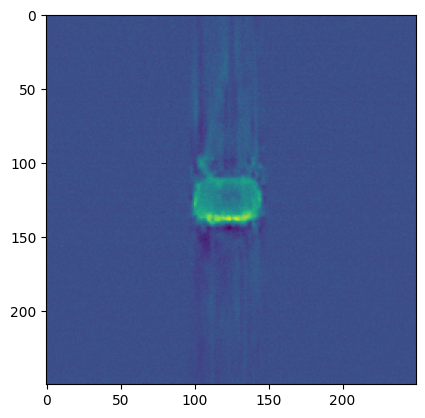

In [ ]:
plt.imshow(rec_image[140,:,:])

In [ ]:
Ncolumns

1190

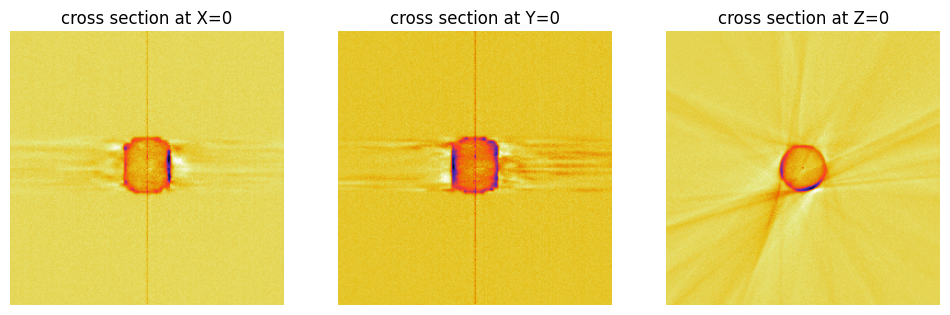

In [ ]:
NimageZ=Nimage*250/250
Z_c=int(NimageZ/2.0)
X_c=int(Nimage/2.0)
Y_c=int(Nimage/2.0)
figure, axis=plt.subplots(1, 3,figsize=(12,12))
axis[0].imshow(rec_image[X_c,:,:].T, cmap='CMRmap_r')
axis[0].set_title('cross section at X=0')
axis[0].axis('off')
axis[1].imshow(rec_image[:,Y_c,:].T, cmap='CMRmap_r')
axis[1].set_title('cross section at Y=0')
axis[1].axis('off')
axis[2].imshow(rec_image[:,:,Z_c].T, cmap='CMRmap_r')
axis[2].set_title('cross section at Z=0')
axis[2].axis('off')
# plt.savefig(directory+"rec_image.pdf",format='pdf',dpi=250)
plt.show()

from mayavi import mlab
# Visualize with Mayavi
mlab.contour3d(rec_image, contours=10, opacity=0.3)
mlab.savefig(directory+'rec_image3D.png')
mlab.show()